<a href="https://colab.research.google.com/github/RileyWClarke/BiancoGroup/blob/master/Notebooks/fftfilter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools


#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18

## Data Collection/Cleaning

In [0]:
filenames = []

for i in range(1000):
    if i<10:
        filenames.append('https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/35000/ktwo20613500'
                         +str(i)+'-c03_llc.fits')
    elif i<100:
        filenames.append('https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/35000/ktwo2061350'
                         +str(i)+'-c03_llc.fits')
    else:
        filenames.append('https://archive.stsci.edu/missions/k2/lightcurves/c3/206100000/35000/ktwo206135'
                         +str(i)+'-c03_llc.fits')

In [3]:
#Read in arrays via astropy.fits.open
d = {}
for j, filename in enumerate(filenames):
    try:
        with fits.open(filename, mode="readonly") as hdulist:
            d["k2bjds{0}".format(j)] = hdulist[1].data['TIME'] 
            d["pdcsap_flux{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX']
            d["pdcsap_flux_err{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX_ERR']
    except: 
        print('no file for loop '+str(j))

no file for loop 0
no file for loop 1
no file for loop 2
no file for loop 3
no file for loop 4
no file for loop 5
no file for loop 6
no file for loop 7
no file for loop 8
no file for loop 9
no file for loop 10
no file for loop 12
no file for loop 13
no file for loop 14
no file for loop 15
no file for loop 16
no file for loop 17
no file for loop 18
no file for loop 19
no file for loop 20
no file for loop 21
no file for loop 22
no file for loop 23
no file for loop 24
no file for loop 25
no file for loop 26
no file for loop 27
no file for loop 28
no file for loop 29
no file for loop 30
no file for loop 31
no file for loop 33
no file for loop 34
no file for loop 35
no file for loop 36
no file for loop 37
no file for loop 38
no file for loop 39
no file for loop 40
no file for loop 41
no file for loop 42
no file for loop 43
no file for loop 44
no file for loop 45
no file for loop 46
no file for loop 47
no file for loop 48
no file for loop 49
no file for loop 50
no file for loop 51
no file fo

In [4]:
#How many objects did we grab total?
len(d)/3

46.0

In [0]:
nanseries = []
for filename in d:
  nanseries.append(d[filename])

In [0]:
#removing nans from arrays
allseries = []
for i in range(len(nanseries)-2)[::3]:
  allseries.append(nanseries[i][np.where((np.isnan(nanseries[i]) == False) & (np.isnan(nanseries[i+1]) == False))[0]][:500])
  allseries.append(nanseries[i+1][(~np.isnan(nanseries[i+1])) & (~np.isnan(nanseries[i]))][:500])
  allseries.append(nanseries[i+2][np.where(np.isnan(nanseries[i+2]) == False)[0]][:500])

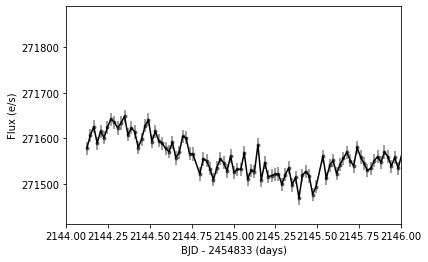

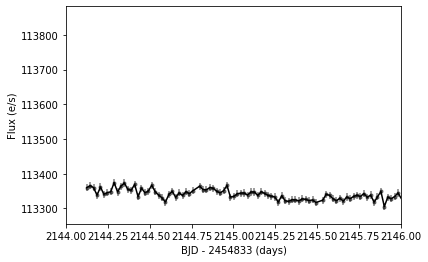

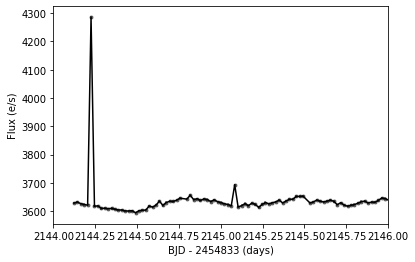

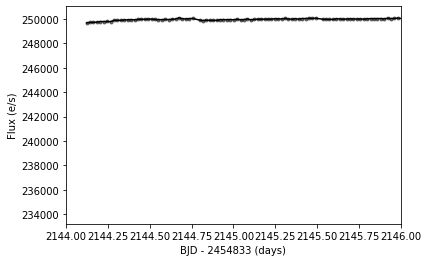

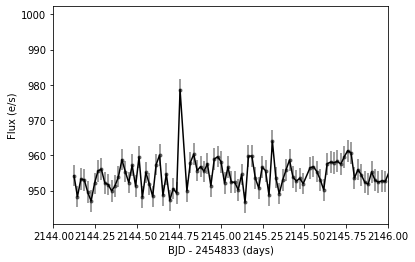

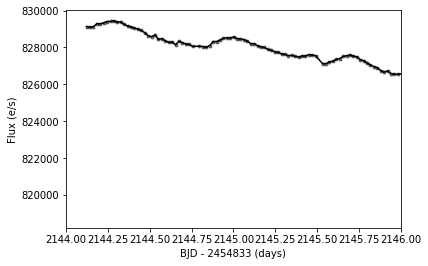

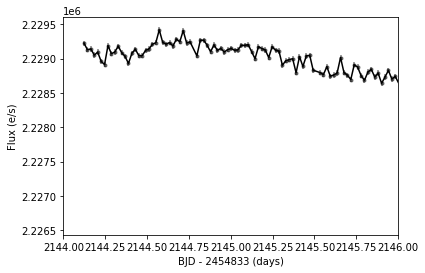

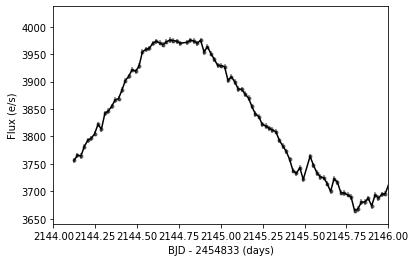

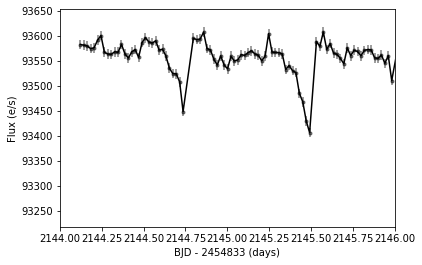

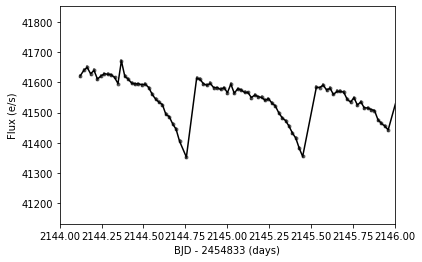

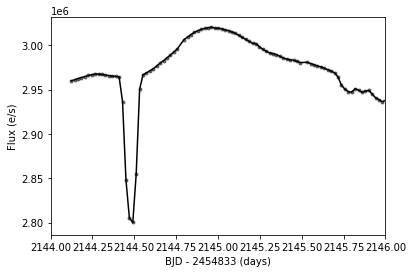

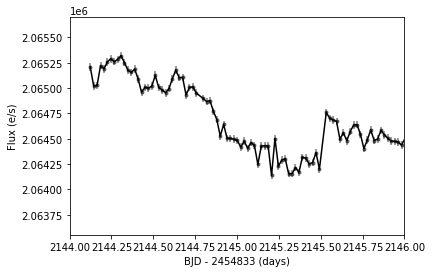

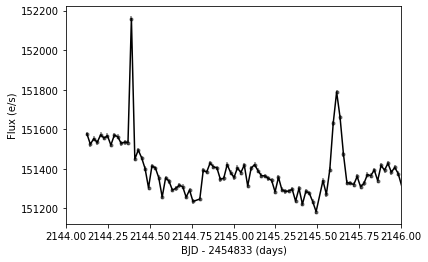

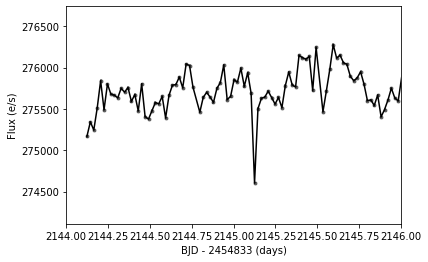

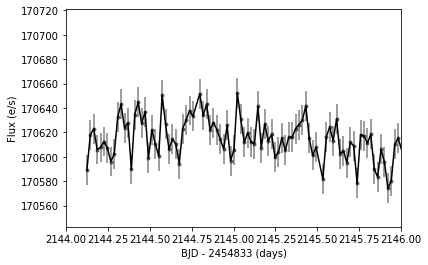

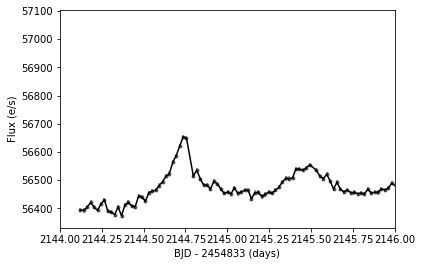

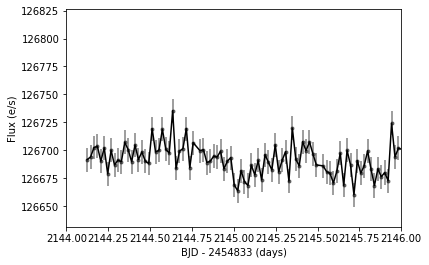

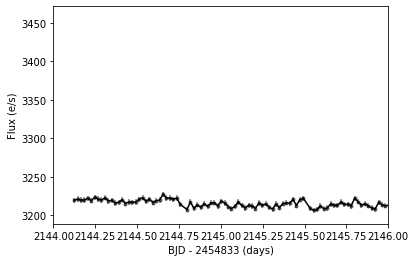

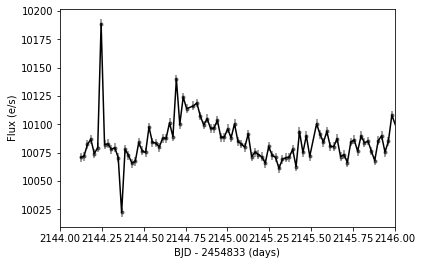

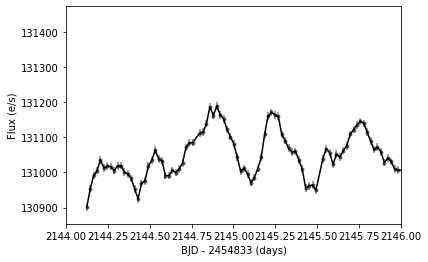

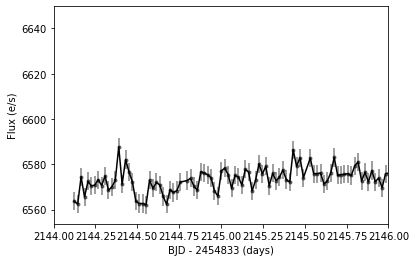

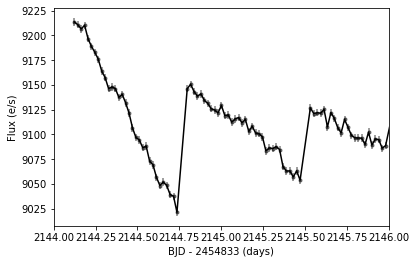

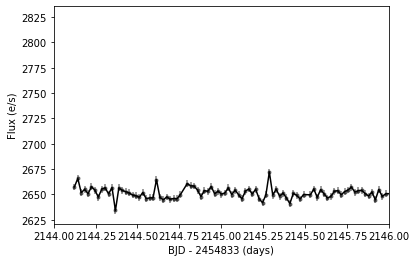

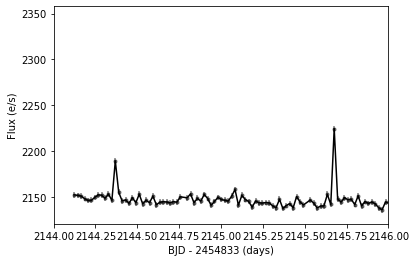

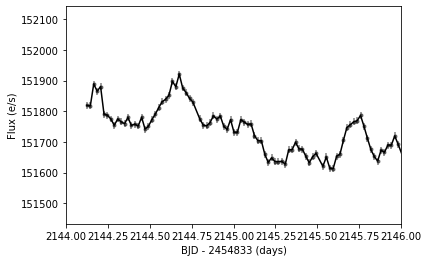

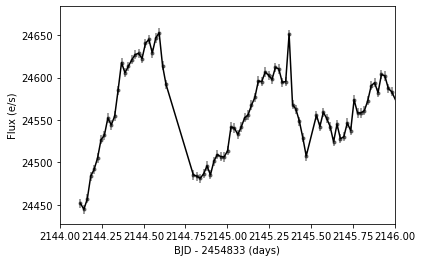

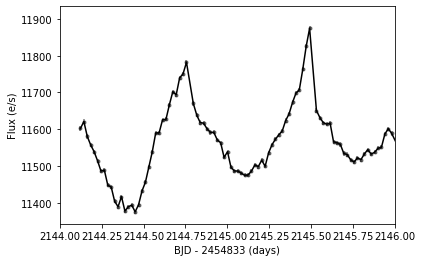

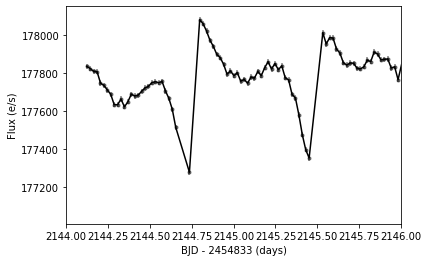

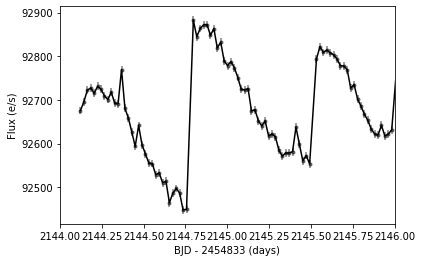

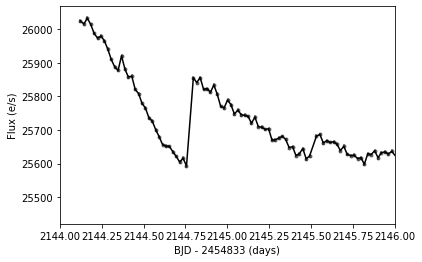

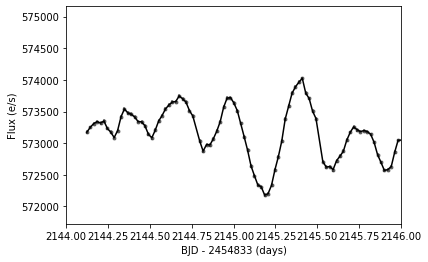

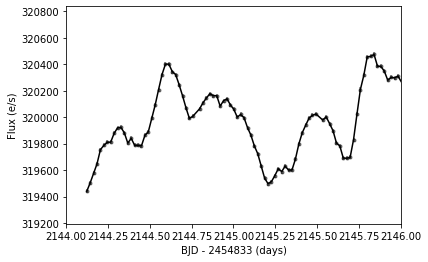

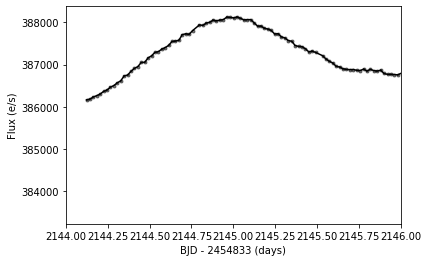

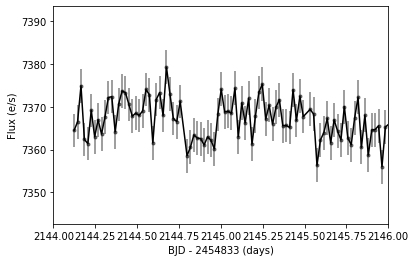

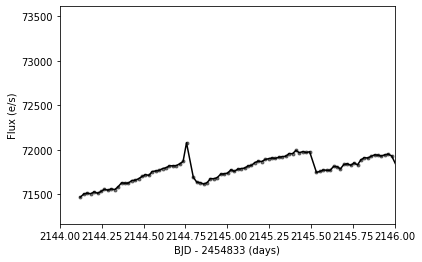

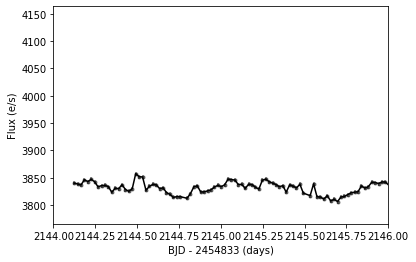

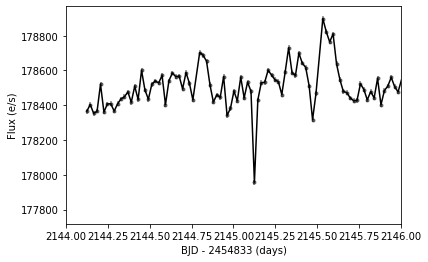

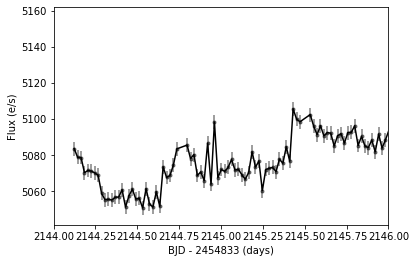

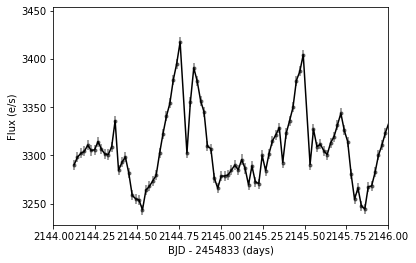

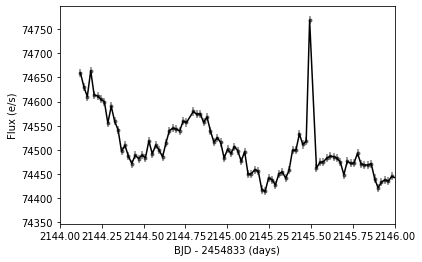

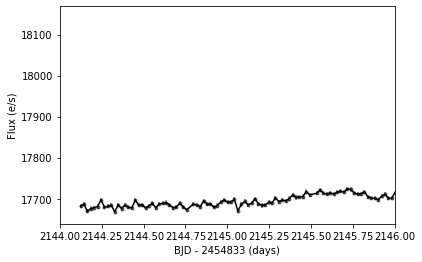

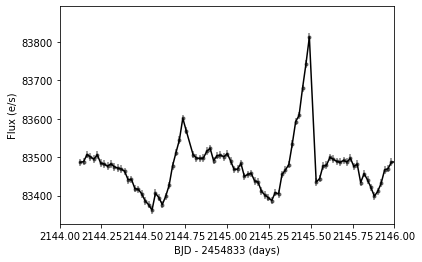

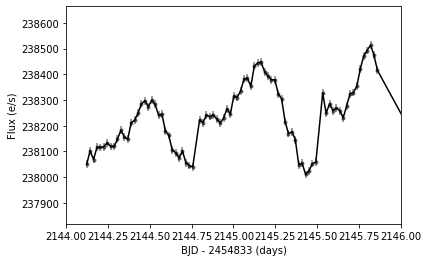

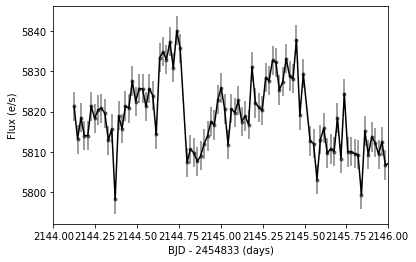

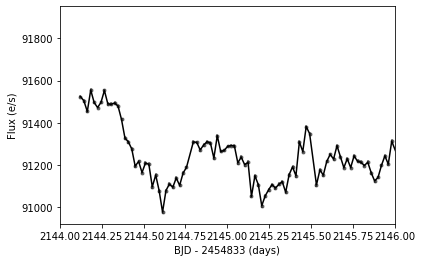

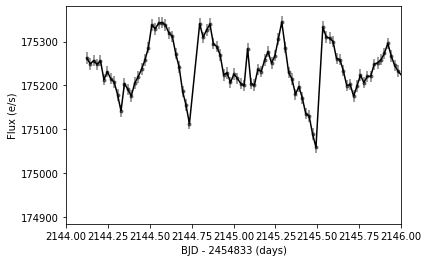

In [8]:
for i in range(len(allseries)-2)[::3]:
  plt.errorbar(allseries[i], allseries[i+1], yerr=allseries[i+2], fmt='k.',alpha=0.5)
  plt.plot(allseries[i], allseries[i+1], c='k')
  plt.xlim(2144,2146)
  plt.ylabel("Flux (e/s)")
  plt.xlabel("BJD - 2454833 (days)")
  plt.show()

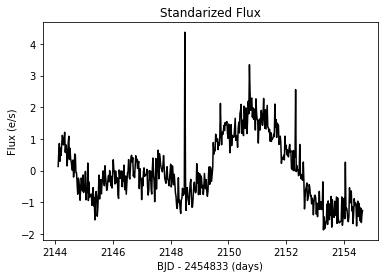

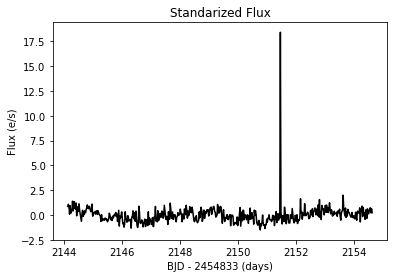

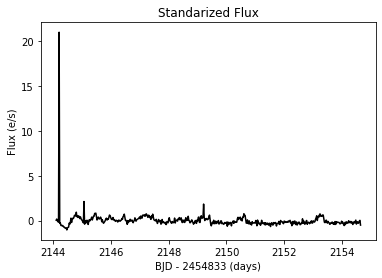

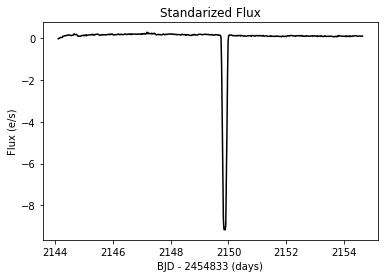

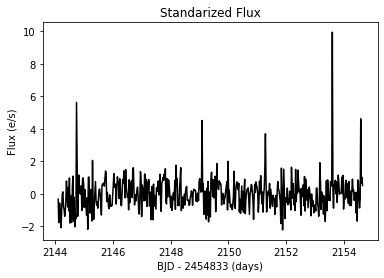

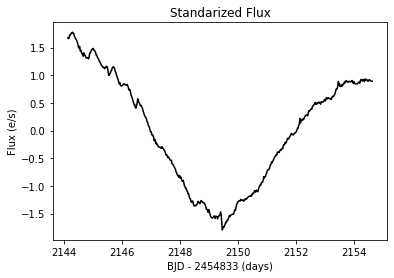

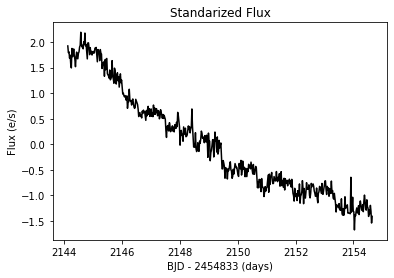

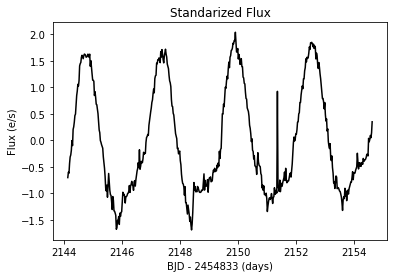

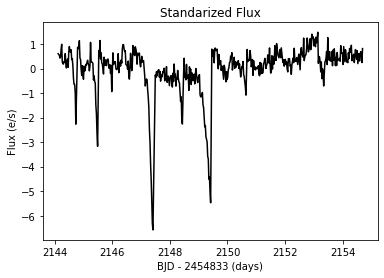

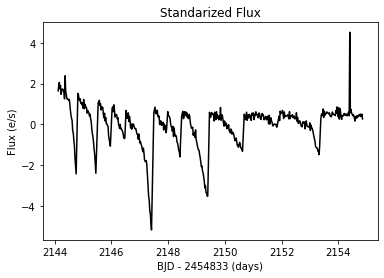

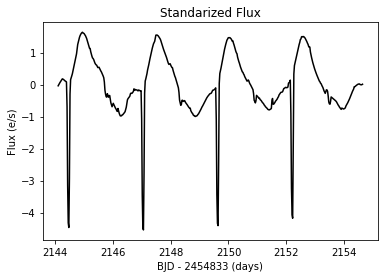

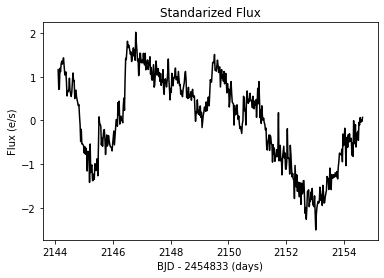

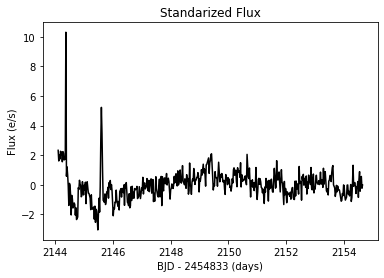

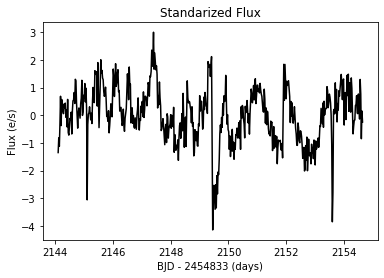

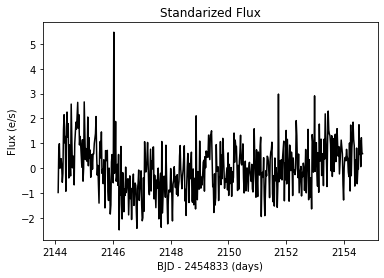

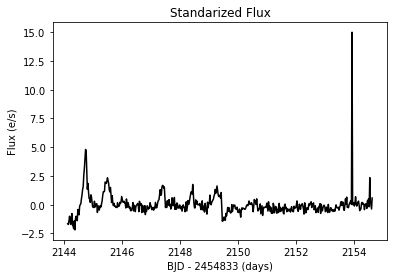

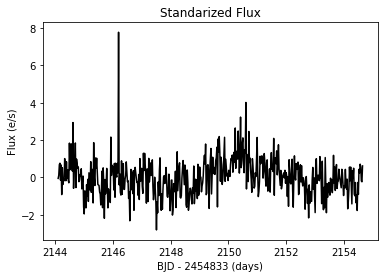

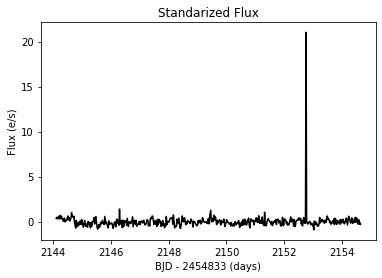

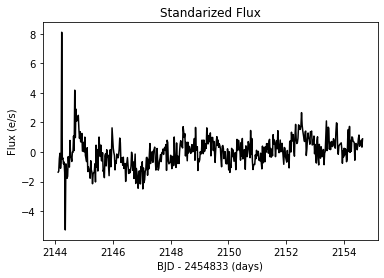

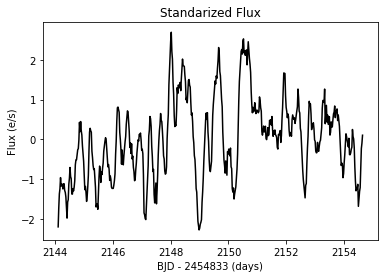

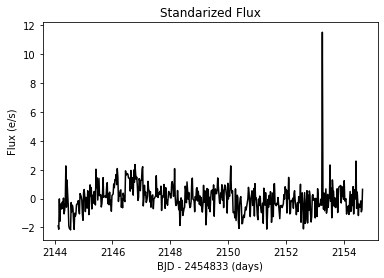

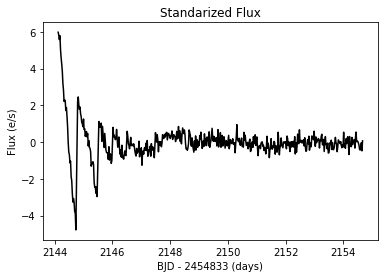

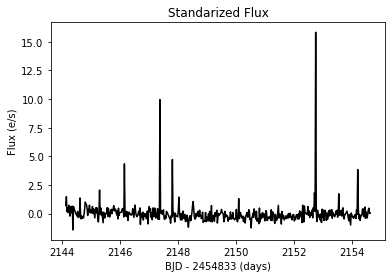

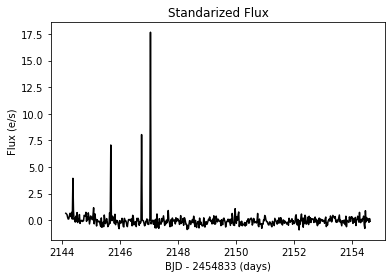

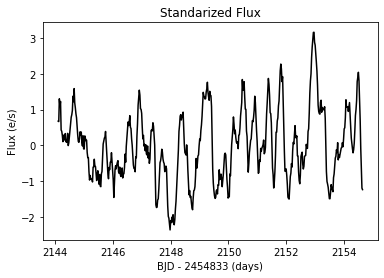

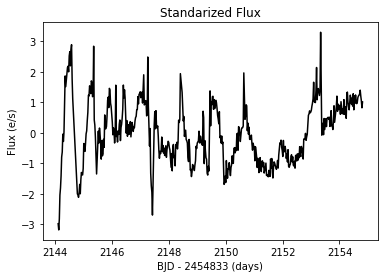

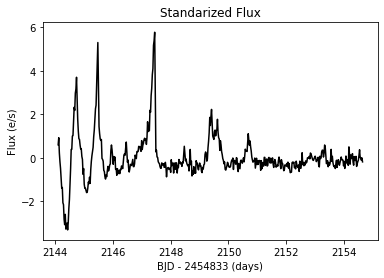

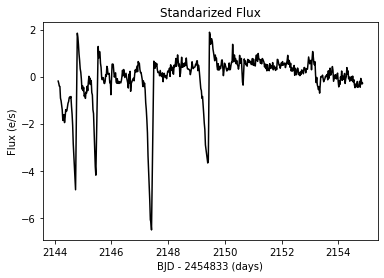

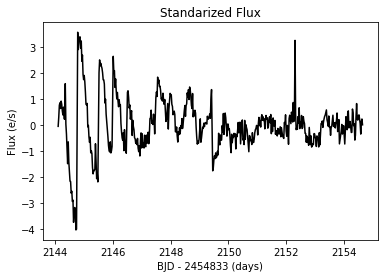

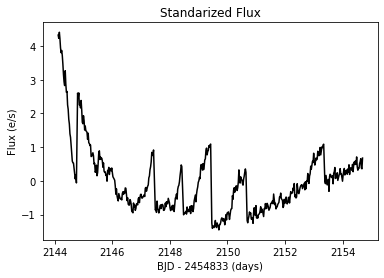

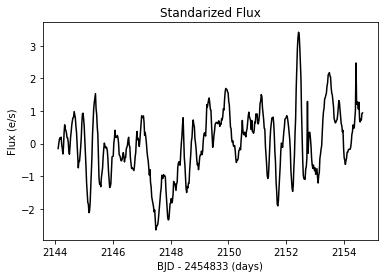

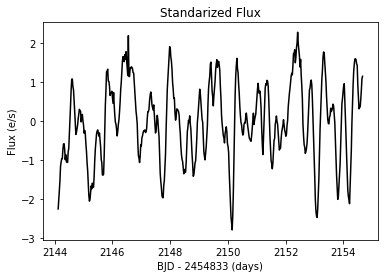

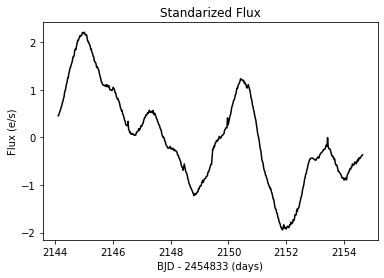

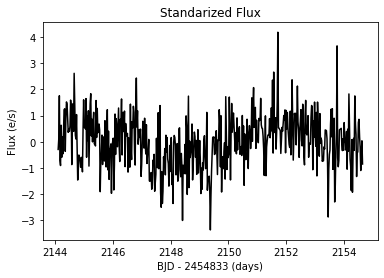

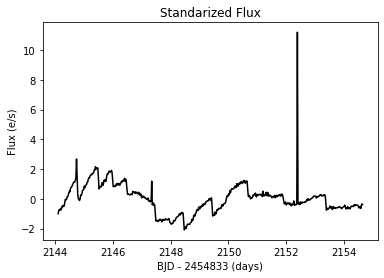

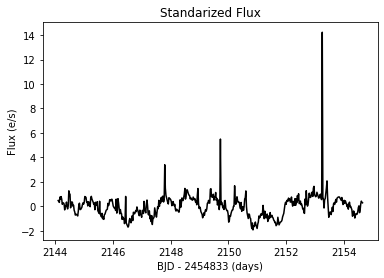

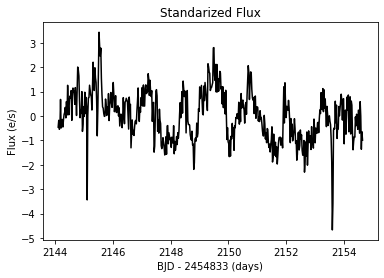

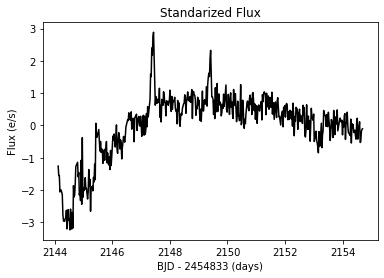

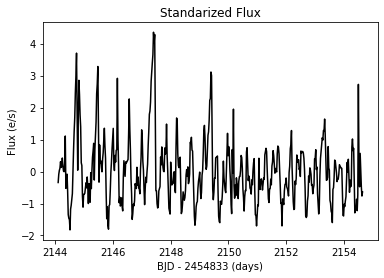

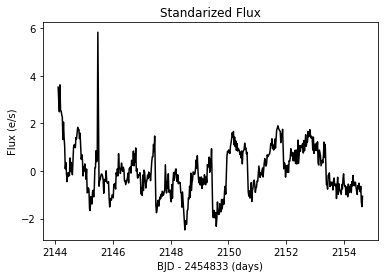

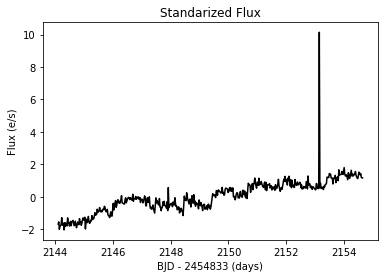

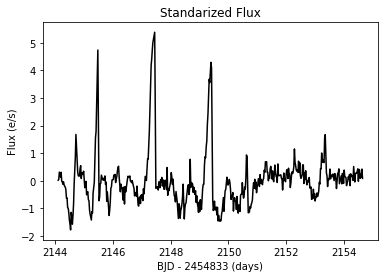

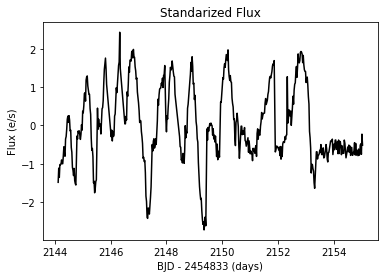

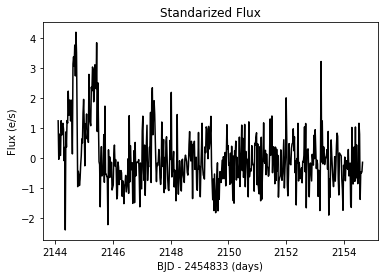

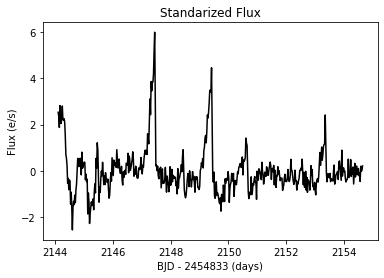

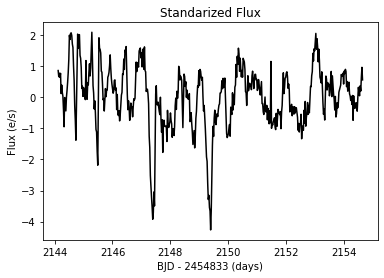

In [9]:
for i in range(len(allseries)-2)[::3]:
  allseries[i+1] = (allseries[i+1] - np.mean(allseries[i+1])) / np.std(allseries[i+1])
  plt.plot(allseries[i], allseries[i+1], c='k')
  plt.ylabel("Flux (e/s)")
  plt.xlabel("BJD - 2454833 (days)")
  plt.title("Standarized Flux")
  plt.show()

## FFT Filtering

In [0]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [0]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=None):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()
    
    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()
    
    if Filter == 'box':
    
        filtered_spectrum = spectrum.copy()
    
        if inv_box == True:
            x_1 = np.arange(0, Low_cutoff, 0.1)
            x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
            plt.plot(freq, spectrum)
            plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
            plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
            plt.title("range to suppress")
            plt.figure()
            filtered_spectrum[lc] = 0.
            filtered_spectrum[hc] = 0.
        else:
            x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
            plt.plot(freq, spectrum)
            plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
            plt.title("range to suppress")
            plt.figure()
            filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
        ig = invgaussian(np.median([low_cutoff,high_cutoff]), gf_sig, freq)
        filtered_spectrum = spectrum * ig
        if ('Gaussian' in Plot) or ('All' in Plot):
          plt.plot(freq, ig)
          plt.title('Gaussian Filter')
          #plt.savefig('Figures/gfilter.png')
          plt.figure()
        
    if ('filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()
    
    
    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal
    if ('PS' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10))
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
    return spectrum, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff
